---
title: 自己教師あり学習(semi-supervised learning)の画像モデルを実装する①
date: 2024-12-19
description: このノートでは、画像分類モデルを自己教師ありで実装していきます。
categories: [kaggle, vision, fastai, semi-supervised]
toc: true
---

# 文脈ベースの画像分類(Context Prediction)

このノートではコードベースで、文脈ベースの画像分類モデルを見ていきます。深層学習にはfastaiライブラリーを、データセットはkaggleの[dl-2024-autum-exp-2](https://www.kaggle.com/competitions/dl-2024-autum-exp-2)競技で提供された画像を使用します。基の論文の[リンク](https://arxiv.org/abs/1505.05192)です。そもそも自己教師あり学習とはなんぞやと言う方は、[こちらのブログ](https://amitness.com/posts/self-supervised-learning)をどうぞ。ざっくりと言えば、ラベル付きの画像データが少ない時、自己教師ありでモデルをファインチューニングさせ、目的のタスクの精度を向上させる学習手法です。従来の教師あり学習との違いは下記の通りです。

従来(教師あり学習)のファインチューニング:

①imagenetで学習されたモデル　→ ②タスク特化のデータを学習

自己教師ありでのファインチューニング:

①imagenetで学習されたモデル　→ ②(NEW) 自己教師あり学習　→ ③タスク特化のデータを学習

--

実装手順:

0. 必要なライブラリーのインストール
1. データセットのインストール
2. 自己教師あり学習用のデータセットを用意
3. 自己教師あり学習モデルのトレーニング
4. タスク特化のデータセットを用意
5. タスク特化モデルのトレーニング
6. まとめ
7. 参照ページ


## 0. 必要なライプラリーのインストール

最新のfastaiライブラリー(記事作成時点で`2.7.18`)が入っていることを確認してください。このノートのコードは、古いバージョンでは動きません。

In [1]:
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle fastai

from fastkaggle import *
import fastai
from fastai.vision.all import *

fastai.__version__

'2.7.18'

## 1. データセットのインストール
競技参加の同意・APIキーの取得を、テータセットのインストール前に行っていきましょう。

In [2]:
!mkdir /root/.config/kaggle
!touch /root/.config/kaggle/kaggle.json

In [3]:
comp = "dl-2024-autum-exp-2"

path = setup_comp(comp)
path.ls()

100%|██████████| 683M/683M [00:09<00:00, 74.8MB/s] 


(#2) [Path('dl-2024-autum-exp-2/sample_submission.csv'),Path('dl-2024-autum-exp-2/food-11_DL_2024')]

In [4]:
!rm -rf temp
!mkdir temp
!cp -r {path}/food-11_DL_2024/training/labeled temp/training
!cp -r {path}/food-11_DL_2024/validation temp/validation
!cp -r {path}/food-11_DL_2024/testing temp/testing

In [5]:
img_files = get_image_files(path); img_files

(#10512) [Path('dl-2024-autum-exp-2/food-11_DL_2024/training/unlabeled/00/6022.jpg'),Path('dl-2024-autum-exp-2/food-11_DL_2024/training/unlabeled/00/1332.jpg'),Path('dl-2024-autum-exp-2/food-11_DL_2024/training/unlabeled/00/3737.jpg'),Path('dl-2024-autum-exp-2/food-11_DL_2024/training/unlabeled/00/4200.jpg'),Path('dl-2024-autum-exp-2/food-11_DL_2024/training/unlabeled/00/2541.jpg'),Path('dl-2024-autum-exp-2/food-11_DL_2024/training/unlabeled/00/1649.jpg'),Path('dl-2024-autum-exp-2/food-11_DL_2024/training/unlabeled/00/3191.jpg'),Path('dl-2024-autum-exp-2/food-11_DL_2024/training/unlabeled/00/5376.jpg'),Path('dl-2024-autum-exp-2/food-11_DL_2024/training/unlabeled/00/2739.jpg'),Path('dl-2024-autum-exp-2/food-11_DL_2024/training/unlabeled/00/5792.jpg'),Path('dl-2024-autum-exp-2/food-11_DL_2024/training/unlabeled/00/4384.jpg'),Path('dl-2024-autum-exp-2/food-11_DL_2024/training/unlabeled/00/5015.jpg'),Path('dl-2024-autum-exp-2/food-11_DL_2024/training/unlabeled/00/3123.jpg'),Path('dl-2024-a

## 2. 自己教師あり学習用のデータセットを用意

今回実装するモデルは、文脈ベースの画像分類(Context Prediction)です。アイデアはシンプルです。画像を`3*3`(或いは`4*4`)のパッチに分けて、二つの隣接する画像をSiameseモデルに学習させ、パッチの場所を推測させる学習方法になります。

イメージ図:

|インプット(X)・アウトプット(Y)|モデル設計|
|---|---|
|![インプット画像・アウトプット](ssl_1.png "インプット・アウトプット")|![モデルアーキテクチャ](ssl_2.png "モデルアーキテクチャ")|




では、まずは画像を9つのバッチに分ける関数を作ります。

In [6]:
import random

def extract_patches(img, grid_sz=3):
    patches, labels = [], []
    w, h = img.size
    tile_w, tile_h = w//grid_sz, h//grid_sz
    for i in range(grid_sz):
        for j in range(grid_sz):
            box = (j*tile_w, i*tile_h, (j+1)*tile_w, (i+1)*tile_h)
            patches.append(img.crop(box))

    idx = random.randint(0, len(patches) - 1)
    main_patch = patches[idx]
    neighbors = [
        (-1, -1), (-1, 0), (-1, 1),
        (0, -1),           (0, 1),
        (1, -1),  (1, 0),   (1, 1)
    ]
    for label, (dx, dy) in enumerate(neighbors):
        ni, nj = (idx//grid_sz) + dx, (idx % grid_sz) + dy
        if 0 <= ni < grid_sz and 0 <= nj < grid_sz:
            neighbor_patch = patches[ni*grid_sz + nj]
            labels.append((main_patch, neighbor_patch, label))
    return labels

extract_patches(PILImage.create(img_files[0]))

[(<PIL.Image.Image image mode=RGB size=170x170>,
  <PIL.Image.Image image mode=RGB size=170x170>,
  0),
 (<PIL.Image.Image image mode=RGB size=170x170>,
  <PIL.Image.Image image mode=RGB size=170x170>,
  1),
 (<PIL.Image.Image image mode=RGB size=170x170>,
  <PIL.Image.Image image mode=RGB size=170x170>,
  3),
 (<PIL.Image.Image image mode=RGB size=170x170>,
  <PIL.Image.Image image mode=RGB size=170x170>,
  5),
 (<PIL.Image.Image image mode=RGB size=170x170>,
  <PIL.Image.Image image mode=RGB size=170x170>,
  6)]

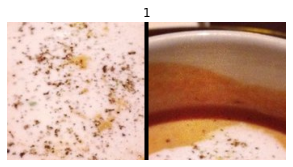

In [7]:
class PatchImage(Tuple):
    def show(self, ctx=None, **kwargs):
        img1, img2, label = self
        if not isinstance(img1, Tensor):
            t1, t2 = image2tensor(img1), image2tensor(img2)
        else: t1, t2 = img1, img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 5)
        return show_image(torch.cat([t1, line, t2], dim=2),
                          title=label, ctx=ctx)

imgs_label = random.choice(extract_patches(PILImage.create(img_files[0])))
PatchImage(imgs_label).show();

画像を`3*3`のパッチに分割したら、その中の1ペア(二つの画像)とそのラベル(隣接するパッチ2の位置)をランダムに選びます。ここでの注意点は、画像をfastaiライブラリー型のPILImageに、またラベルをtensor型に変換する必要がある点です。後の画像処理(ResizeやToTensor)はPILImage型にだけ適用されるトランスフォーマーです。逆にPILImage型への変換なしでは、必要な画像処理は適用されません。またfastaiの古いバージョンではここでエラーが出ます。

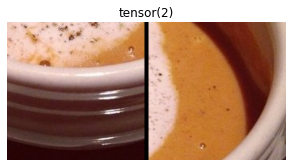

In [8]:
class PatchTransform(Transform):
    def __init__(self, grid_sz=3):
        self.grid_sz = grid_sz

    def encodes(self, f):
        img = PILImage.create(f)
        img1, img2, label = random.choice(extract_patches(img, grid_sz=self.grid_sz))
        img1, img2, label = PILImage.create(img1), PILImage.create(img2), torch.tensor(label).long()
        return PatchImage((img1, img2, label))

PatchTransform()(img_files[0]).show();

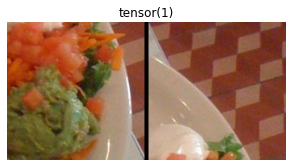

In [9]:
tls = TfmdLists(img_files, PatchTransform(), splits=RandomSplitter(0.1)(img_files))
show_at(tls.valid, 1);

データセットを用意したら、バッチの形`(batch number, channel, height, width)`であることを確認します。今回のデータセットは2つの画像と1つのラベルです。

In [10]:
dls = tls.dataloaders(after_item=[Resize(128), ToTensor],
                      after_batch=[IntToFloatTensor, *aug_transforms(do_flip=False, mult=0.03), Normalize.from_stats(*imagenet_stats)])
x1, x2, y = dls.one_batch()
x1.shape, x2.shape, y.shape

(torch.Size([64, 3, 128, 128]),
 torch.Size([64, 3, 128, 128]),
 torch.Size([64]))

## 3. 自己教師あり学習モデルのトレーニング

データローダーの用意ができましたら、次はモデル設計です。ここでは`xresnet`を使用して設計を簡略化しています。詳しい実装方法は[fastai のチュートリアル](https://docs.fast.ai/tutorial.siamese.html#train-the-model)を参照してください。大事な実装点は、エンコーダーには重みを共有したCNNモデル(resnet以外も可)を使用します。`model_meta[arch]["cut"]`でモデルのbody部分(headを取り除いた)の情報を取得しています。

SuggestedLRs(valley=0.005248074419796467, slide=0.2089296132326126)

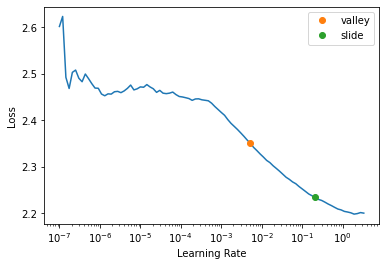

In [11]:
class PatchModel(Module):
    def __init__(self, encoder, head):
        self.encoder, self.head = encoder, head

    def forward(self, x1, x2):
        feats = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
        return self.head(feats)


encoder = create_body(xresnet18(), cut=model_meta[xresnet18]["cut"])
head = create_head(512*2, 8, bn_final=True)
def splitter(model): return [params(model.encoder), params(model.head)]

learn = Learner(dls, PatchModel(encoder, head),
                splitter=splitter,
                loss_func=LabelSmoothingCrossEntropyFlat(),
                metrics=accuracy).to_fp16()
learn.lr_find(suggest_funcs=(valley, slide))

モデルのトレーニングを開始します。学習後は、モデルのエンコーダー(body部分のみ)の重みを保存します。後の分類タスクに、保存された学習済み重みを使用します。

In [14]:
learn.fine_tune(8, 3e-2, wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,2.065364,2.055045,0.176974,00:11


epoch,train_loss,valid_loss,accuracy,time
0,2.034549,2.007366,0.215033,00:12
1,2.014729,1.965503,0.252141,00:12
2,1.937564,1.877558,0.265461,00:12
3,1.864192,1.791731,0.340628,00:12
4,1.793791,1.686071,0.413892,00:12
5,1.735727,1.655852,0.398668,00:12
6,1.696479,1.614018,0.426261,00:12
7,1.693841,1.626468,0.445290,00:12


In [15]:
torch.save(learn.model.encoder.state_dict(), path/"pretrained.pt")

## 4. タスク特化のデータセットを用意

画像分類(本来のタスク)のデータセットを用意して、表示します。

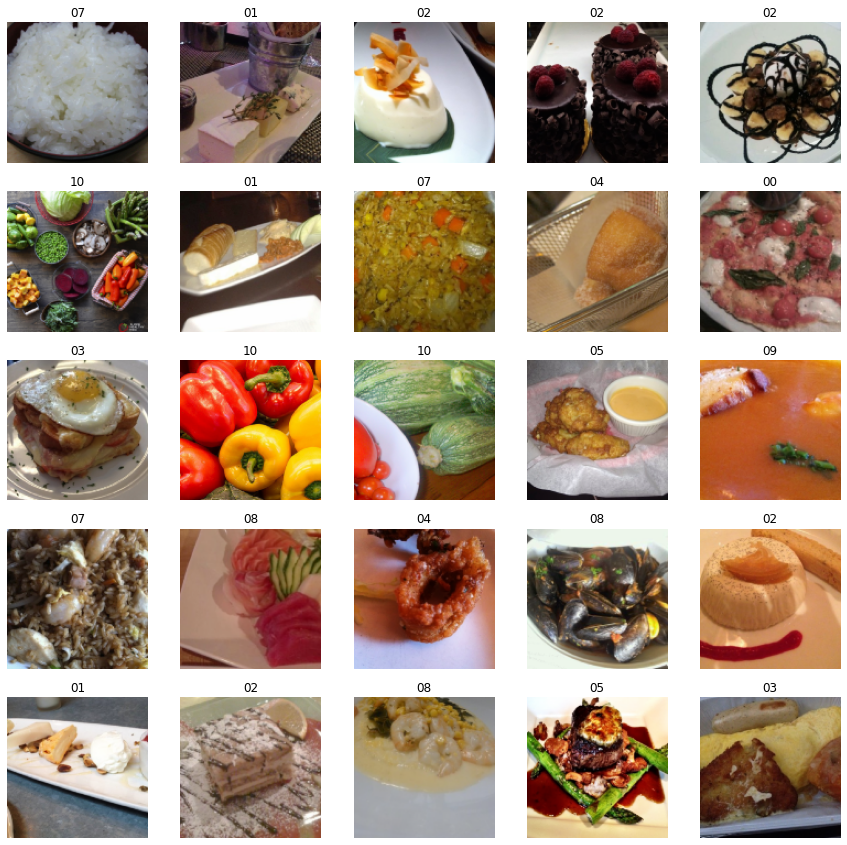

In [16]:
def get_dls(size=128, bs=128):
    return DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        get_y=parent_label,
        splitter=GrandparentSplitter(train_name="training", valid_name="validation"),
        item_tfms=Resize(512),
        batch_tfms=[*aug_transforms(size=size, min_scale=0.7),
                    Normalize.from_stats(*imagenet_stats)]
    ).dataloaders(Path("temp"), bs=bs, num_workers=8)

dls = get_dls(128, 128)
dls.show_batch(max_n=25, nrows=5, ncols=5)

In [26]:
print(f"training sample is : {len(dls.train_ds)}")
print(f"training sample is : {len(dls.valid_ds)}")
print(f"unique targets are: {dls.vocab}")

training sample is : 2464
training sample is : 561
unique targets are: ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10']


## 5. タスク特化モデルのトレーニング

データセットを用意したら、モデルのトレーニングに移ります。ここでのポイントは、先ほどの学習済み重みを使用する点です。使用するエンコーダーは同じモデル設計(ここでは`xresnet18`)であることも注意点です。`encoder.load_state_dict`メソッドで学習済みの重みを取得します。

Started loading weights
Finished loading weights


SuggestedLRs(valley=0.0030199517495930195, slide=0.0831763744354248)

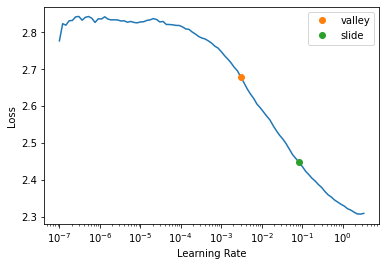

In [21]:
def load_learned_encoder(pretrained=False):
    encoder = create_body(xresnet18(), cut=model_meta[xresnet18]["cut"])
    if pretrained:
        print("Started loading weights")
        encoder.load_state_dict(torch.load(path/"pretrained.pt"))
        print("Finished loading weights")
    return encoder

def get_learner(pretrained=False):
    return vision_learner(dls, load_learned_encoder,
                          normalize=False,
                          pretrained=pretrained,
                          custom_head=create_head(256, dls.c, bn_final=True),
                          loss_func=LabelSmoothingCrossEntropyFlat(),
                          metrics=accuracy).to_fp16()

learn = get_learner(pretrained=True)
learn.lr_find(suggest_funcs=(valley, slide))

In [22]:
learn.fine_tune(8, 1e-2, wd=0.03)

epoch,train_loss,valid_loss,accuracy,time
0,2.365422,2.788396,0.294118,00:07


epoch,train_loss,valid_loss,accuracy,time
0,2.023843,2.036399,0.358289,00:07
1,1.986245,1.982175,0.386809,00:07
2,1.948719,1.943361,0.402852,00:07
3,1.909655,1.874451,0.406417,00:07
4,1.868977,1.840779,0.429590,00:07
5,1.840563,1.811273,0.424242,00:07
6,1.808802,1.793990,0.440285,00:07
7,1.786897,1.793903,0.443850,00:07


ついでに自己教師あり学習なし(従来の教師あり学習のみ)で、モデルのトレーニングをしてみましょう。平均すると、自己教師ありモデルと比べて、3%くらいaccuracy精度が落ちます。

In [24]:
learn = get_learner(pretrained=False)
learn.fine_tune(8, 1e-2, wd=0.01)

epoch,train_loss,valid_loss,accuracy,time
0,2.349318,2.642091,0.256684,00:07


epoch,train_loss,valid_loss,accuracy,time
0,2.012004,2.145106,0.340463,00:07
1,1.986448,2.036883,0.368984,00:07
2,1.963871,2.034508,0.370766,00:07
3,1.934942,1.942387,0.406417,00:07
4,1.902483,1.917247,0.386809,00:07
5,1.876937,1.903317,0.393939,00:07
6,1.844684,1.887917,0.408200,00:07
7,1.824337,1.880563,0.413547,00:07


最後に、インストールしたデータセットを削除します。

In [25]:
!rm -rf {path}
!rm -rf temp
!rm -rf dl-2024-autum-exp-2.zip

## 6. まとめ

自己教師あり学習をコードベースで見ていきました。データを用意する際の一番のボトルネックがラベル付けです。手作業のラベル付けなしで、データに含まれている要素から、ラベルをプログラミング的に付与できるのはとても実用的な学習方法です。
次の記事では、今回のモデルの派生型であるジグソーパズルモデルをみていきます。

もしも読者がこのノートを役に立ったと思ったら、リアクションボタンを押してもらえると幸いです。質問や間違いがあれば、以下コメント欄に書き込んでください。

## 7. 参照ページ

* [Context Predictionの論文](https://arxiv.org/pdf/1505.05192)
* [トレーニングに使用したデータ](https://www.kaggle.com/competitions/dl-2024-autum-exp-2)
* [自己教師あり学習を説明したブログ記事](https://amitness.com/posts/self-supervised-learning)
* [ロテーション(文脈ベースの自己教師あり)モデルの実装ブログ](https://amarsaini.github.io/Epoching-Blog/jupyter/2020/03/23/Self-Supervision-with-FastAI.html)
* [fastaiのSiameseモデル実装のチュートリアル](https://docs.fast.ai/tutorial.siamese.html)